In [7]:
# 1.0 - Obtención y Unificación de Datos Médicos
# ==============================================================================
# Este notebook se encarga de:
# 1. Descargar el dataset 'CodiEsp' (Casos clínicos en Español).
# 2. Descargar y procesar 'MTSamples' (Casos clínicos en Inglés).
# 3. Traducir y adaptar las etiquetas para unificar ambos mundos.
# 4. Generar un dataset maestro balanceado y listo para el preprocesamiento.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datasets import load_dataset
from deep_translator import GoogleTranslator
from tqdm.notebook import tqdm
import random

print("✅ librerías cargadas.")

✅ librerías cargadas.


In [8]:
# Configuración de Rutas
RAW_DATA_PATH = '../data/raw/'
PROCESSED_DATA_PATH = '../data/processed/'

# Crear carpetas si no existen
os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

# Configuración para que las tablas se vean estéticamente agradables
pd.set_option('display.max_colwidth', 150)

print("✅ Entorno configurado")

✅ Entorno configurado


In [9]:
print("📥 Cargando dataset CodiEsp desde HuggingFace...")

# 1. Descarga
try:
    ds = load_dataset("bigbio/codiesp", "codiesp_D_bigbio_text", trust_remote_code=True)
    df_codiesp = pd.DataFrame(ds['train'])
except Exception as e:
    print(f"❌ Error descargando CodiEsp: {e}")

# 2. Diccionario de Mapeo (CIE-10 -> Especialidad)
mapa_especialidades = {
    'A': 'Infecciosas/Parasitarias', 'B': 'Infecciosas/Parasitarias', 'C': 'Oncología (Tumores)',
    'D': 'Sangre/Inmunología', 'E': 'Endocrinología/Nutrición', 'F': 'Psiquiatría/Mental',
    'G': 'Neurología', 'H': 'Oftalmología/ORL', 'I': 'Cardiología/Circulatorio', 'J': 'Respiratorio/Neumología',
    'K': 'Gastroenterología/Digestivo', 'L': 'Dermatología', 'M': 'Traumatología/Muscular', 'N': 'Urología/Renal',
    'O': 'Ginecología/Obstetricia', 'P' : 'Pediatría', 'R': 'Medicina General', 
    'S': 'Traumatología/Muscular', 'T': 'Medicina General', 'V' : 'Urgencias/Trauma',
    'W': 'Urgencias/Trauma', 'X': 'Urgencias/Trauma', 'Y': 'Urgencias/Trauma', 'Z': 'Medicina General'
    }

def clasificar_cie10(lista_labels):
    if not isinstance(lista_labels, list) or len(lista_labels) == 0:
        return 'Medicina General'
    codigo = lista_labels[0]
    letra = str(codigo)[0].upper()
    return mapa_especialidades.get(letra, 'Medicina General')

# 3. Procesamiento
df_codiesp['especialidad'] = df_codiesp['labels'].apply(clasificar_cie10)
df_codiesp = df_codiesp.rename(columns={'text': 'sintomas'})
df_codiesp = df_codiesp[['sintomas', 'especialidad']] # Solo columnas útiles

print(f"✅ CodiEsp procesado: {len(df_codiesp)} filas.")
display(df_codiesp.head(2))

📥 Cargando dataset CodiEsp desde HuggingFace...
✅ CodiEsp procesado: 500 filas.


,sintomas,especialidad
0,Describimos el caso de un varón de 37 años con vida previa activa que refiere dolores osteoarticulares de localización variable en el último mes y...,Urología/Renal
1,Se trata de una mujer de 29 años sometida a un estudio ecográfico pélvico de control tras una ligadura de trompas por vía laparoscópica. Durante e...,Sangre/Inmunología


In [10]:
# Nombre del archivo intermedio para no retraducir siempre
ARCHIVO_TRADUCIDO = os.path.join(RAW_DATA_PATH, 'mtsamples_translated.csv')

# Mapeo de Inglés a tus etiquetas en Español
mapeo_ingles = {
    'Orthopedic': 'Traumatología/Muscular',
    'Gastroenterology': 'Gastroenterología/Digestivo',
    'Urology': 'Urología/Renal',
    'Neurology': 'Neurología',
    'Cardiovascular / Pulmonary': 'Cardiología/Circulatorio',
    'Obstetrics / Gynecology' : 'Ginecología/Obstetricia',
    'Hematology - Oncology' : 'Oncología (Tumores)',
    'General Medicine' : 'Medicina General',
    'Allergy / Immunology' : 'Sangre/Inmunología',
    'Bariatrics' : 'Endocrinología/Nutrición',
    'Diets and Nutritions' : 'Endocrinología/Nutrición',
    'Endocrinology' : 'Endocrinología/Nutrición',
    'Chiropractic' : 'Traumatología/Muscular',
    'Dermatology' : 'Dermatología',
    'ENT - Otolaryngology' : 'Oftalmología/ORL',
    'Ophthalmology' : 'Oftalmología/ORL',
    'Nephrology' : 'Urología/Renal',
    'Sleep Medicine' : 'Neurología',
    'Speech - Language' : 'Neurología',
    'Neurosurgery' : 'Neurología',
    'Physical Medicine - Rehab' : 'Traumatología/Muscular',
    'Podiatry' : 'Traumatología/Muscular',
    'Rheumatology' : 'Traumatología/Muscular',
    'Psychiatry / Psychology' : 'Psiquiatría/Mental',
    'Dentistry' : 'Odontología',
    'Pediatrics - Neonatal' : 'Pediatría'
    }

if os.path.exists(ARCHIVO_TRADUCIDO):
    print("📂 Archivo traducido encontrado. Cargando directamente...")
    df_mt_ready = pd.read_csv(ARCHIVO_TRADUCIDO)
else:
    print("🇺🇸 Cargando MTSamples original para traducir...")
    try:
        df_en = pd.read_csv(os.path.join(RAW_DATA_PATH, 'mtsamples.csv'))
        
        # Filtrar y Mapear
        df_en['medical_specialty'] = df_en['medical_specialty'].str.strip()
        df_filtered = df_en[df_en['medical_specialty'].isin(mapeo_ingles.keys())].copy()
        df_filtered['especialidad'] = df_filtered['medical_specialty'].map(mapeo_ingles)
        
        # Preparar para traducción
        df_mt_ready = df_filtered[['transcription', 'especialidad']].dropna()
        df_mt_ready = df_mt_ready.rename(columns={'transcription': 'sintomas'})
        
        # TRADUCCIÓN (Esto tarda)
        print("⏳ Iniciando traducción (Google Translator)...")
        traductor = GoogleTranslator(source='en', target='es')
        tqdm.pandas()
        
        # Traducimos solo los primeros 400 caracteres para agilizar
        df_mt_ready['sintomas'] = df_mt_ready['sintomas'].progress_apply(
            lambda x: traductor.translate(x[:400]) if pd.notnull(x) else np.nan
        )
        
        df_mt_ready = df_mt_ready.dropna()
        
        # Guardar copia de seguridad
        df_mt_ready.to_csv(ARCHIVO_TRADUCIDO, index=False)
        print("✅ Traducción completada y guardada.")
        
    except FileNotFoundError:
        print("⚠️ ADVERTENCIA: No se encontró 'mtsamples.csv' en data/raw/. Se omitirá esta fuente.")
        df_mt_ready = pd.DataFrame(columns=['sintomas', 'especialidad'])

print(f"✅ Datos MTSamples listos: {len(df_mt_ready)} filas.")
display(df_mt_ready.head(2))

📂 Archivo traducido encontrado. Cargando directamente...
✅ Datos MTSamples listos: 2505 filas.


,sintomas,especialidad
0,"SUBJETIVO: Esta mujer blanca de 23 años se queja de alergias. Solía ​​tener alergias cuando vivía en Seattle, pero cree que aquí son peores. En ...",Sangre/Inmunología
1,"ANTECEDENTES MÉDICOS ANTERIORES: Tiene dificultad para subir escaleras, dificultad con los asientos de avión, atarse los zapatos, está acostumbrad...",Endocrinología/Nutrición


In [11]:
# Generar datos unicos para aumentar data para entrenamiento con modismos ecuatorianos.
# Configuración
NUM_REGISTROS = 20000
OUTPUT_PATH = '../data/raw/dataset_medico_ecuador_50k.csv'
os.makedirs('../data/raw', exist_ok=True)

# 1. Especialidades y sus vocabularios (Formal + Coloquial Ecuador)
base_conocimiento = {
    "Cardiología": {
        "formal": ["dolor precordial opresivo", "palpitaciones taquicárdicas", "disnea de esfuerzo", "edema en miembros inferiores", "síncope vasovagal", "hipertensión arterial descontrolada", "angina de pecho estable"],
        "coloquial": ["siento como una pata de elefante en el pecho", "me palpita feo el corazón", "se me va el aire al subir gradas", "tengo las piernas hinchadas como tamal", "me dio un soponcio y me caí", "tengo la presión por las nubes", "me hinca el corazón"]
    },
    "Gastroenterología": {
        "formal": ["epigastralgia urente", "distensión abdominal", "reflujo gastroesofágico", "hematemesis", "dispepsia funcional", "colitis ulcerosa", "ictericia marcada"],
        "coloquial": ["me arde la boca del estómago", "estoy aventado", "se me regresa la comida agria", "estoy vomitando sangre", "me cae mal todo lo que como", "tengo el colon inflamado", "estoy amarillo como patito"]
    },
    "Neumología": {
        "formal": ["tos productiva con esputo", "sibilancias espiratorias", "disnea paroxística nocturna", "hemoptisis", "dolor pleurítico"],
        "coloquial": ["tengo tos de perro con flema", "me chilla el pecho al respirar", "me ahogo cuando estoy durmiendo", "estoy tosiendo sangre", "me punza la espalda al respirar"]
    },
    "Neurología": {
        "formal": ["cefalea tensional holocraneal", "parestesias en hemicuerpo", "crisis convulsiva tónico-clónica", "vértigo periférico", "migraña con aura"],
        "coloquial": ["me duele toda la cabeza como si tuviera una vincha", "siento hormigueo en medio cuerpo", "le dio el ataque y se sacudió", "todo me da vueltas y me tumba", "veo lucecitas antes de que me duela la cabeza"]
    },
    "Traumatología": {
        "formal": ["algia lumbar mecánica", "edema y equimosis post-traumática", "limitación funcional articular", "fractura expuesta", "cervicalgia post-latigazo"],
        "coloquial": ["me duele la cintura bajito", "tengo morado y soplado después del golpe", "no puedo mover la rodilla ni un poquito", "se me salió el hueso", "tengo el cuello tieso por el frenazo"]
    },
    "Pediatría": {
        "formal": ["pirexia no cuantificada", "erupción exantemática", "irritabilidad y llanto constante", "intolerancia a la vía oral", "tos ferina"],
        "coloquial": ["el guagua está hirviendo en fiebre", "le salieron granitos en todo el cuerpo", "el nene no para de llorar", "todo lo que come lo vomita", "tiene una tos que no se le quita"]
    },
    "Ginecología": {
        "formal": ["dismenorrea incapacitante", "leucorrea fétida", "sangrado uterino anormal", "mastalgia cíclica", "prurito vulvar"],
        "coloquial": ["me vienen unos cólicos que me tumban", "tengo un descenso que huele mal", "me baja la regla muy fuerte y a deshora", "me duelen los senos antes de la menstruación", "tengo una picazón allá abajo"]
    },
    "Emergencias": {
        "formal": ["traumatismo craneoencefálico", "herida cortopunzante profusa", "quemadura de segundo grado", "intoxicación exógena", "anafilaxia"],
        "coloquial": ["se rompió la cabeza en la caída", "se cortó feo y sale mucha sangre", "se quemó con agua hirviendo", "se tomó un veneno", "se está hinchando todo y no respira"]
    },
    "Dermatología": {
        "formal": ["dermatitis atópica", "alopecia areata", "acné nódulo-quístico", "micosis cutánea", "nevus displásico"],
        "coloquial": ["tengo sarpullido que pica mucho", "se me está cayendo el pelo por parches", "tengo la cara llena de granos feos", "tengo hongos en la piel", "me salió un lunar raro"]
    },
    "Otorrinolaringología": {
        "formal": ["otalgia derecha", "epistaxis anterior", "hipoacusia súbita", "vértigo posicional", "odinofagia intensa"],
        "coloquial": ["me duele full el oído derecho", "me sale sangre de la nariz", "me quedé sordo de golpe", "me mareo si muevo la cabeza", "no puedo ni tragar del dolor de garganta"]
    },
    "Psiquiatría": {
        "formal": ["insomnio de conciliación", "ánimo depresivo persistente", "crisis de ansiedad generalizada", "alucinaciones auditivas", "ideación suicida"],
        "coloquial": ["no puedo pegar el ojo en toda la noche", "no tengo ganas de hacer nada, solo llorar", "me siento muy nervioso y con miedo", "escucho voces que nadie más oye", "tengo ganas de quitarme la vida"]
    },
    "Urología": {
        "formal": ["disuria y polaquiuria", "hematuria macroscópica", "cólico renoureteral", "disfunción eréctil", "dolor testicular agudo"],
        "coloquial": ["me arde para orinar y voy a cada rato", "estoy orinando sangre", "tengo un dolor en el riñón que me dobla", "tengo problemas de potencia sexual", "me duele mucho un testículo"]
    },
    "Oftalmología": {
        "formal": ["disminución de la agudeza visual", "hiperemia conjuntival", "fotofobia", "miodesopsias", "diplopía"],
        "coloquial": ["ya no veo bien las letras de lejos", "tengo el ojo rojo como tomate", "la luz me molesta muchísimo", "veo mosquitas volando", "estoy viendo doble"]
    },
    "Odontología": {
        "formal": ["odontalgia severa", "gingivorragia", "halitosis", "absceso periodontal", "bruxismo"],
        "coloquial": ["me duele la muela horrible", "me sangran las encías al cepillarme", "tengo mal aliento", "tengo un nacido en la encía", "rechinar los dientes al dormir"]
    },
    "Endocrinología": {
        "formal": ["polidipsia y poliuria", "aumento de peso injustificado", "intolerancia al frío", "temblor distal fino", "diaforesis excesiva"],
        "coloquial": ["tengo mucha sed y orino bastante", "estoy engordando sin comer tanto", "paso con frío todo el tiempo", "me tiemblan las manos", "sudo demasiado sin hacer nada"]
    },
    "Infectología": {
        "formal": ["fiebre de origen desconocido", "adenopatías generalizadas", "síndrome febril agudo", "lesiones herpéticas", "sudoración nocturna"],
        "coloquial": ["tengo una fiebre que no se me va", "tengo bolas en el cuello y axilas", "estoy con calentura y cuerpo cortado", "me salieron ampollas dolorosas", "mojo la cama de sudor en la noche"]
    },
    "Nefrología": {
        "formal": ["edema periorbitario", "oliguria", "dolor en fosa renal", "proteinuria espumosa", "hipertensión resistente"],
        "coloquial": ["amanecí con los ojos hinchados", "casi no estoy orinando nada", "me duele la espalda baja a los lados", "la orina sale con mucha espuma", "la presión no me baja con nada"]
    },
    "Reumatología": {
        "formal": ["artralgias matutinas", "rigidez articular", "dolor poliarticular", "fenómeno de Raynaud", "deformidad articular"],
        "coloquial": ["me duelen las coyunturas al despertar", "amanezco tieso", "me duelen todas las uniones", "se me ponen los dedos blancos con el frío", "se me están enchuecando los dedos"]
    },
    "Oncología": {
        "formal": ["pérdida de peso caquectizante", "masa palpable no dolorosa", "disfagia progresiva", "cambios en hábito intestinal", "hemorragia digestiva oculta"],
        "coloquial": ["me estoy secando de lo flaco", "me siento una bola dura que no duele", "se me atranca la comida al pasar", "ya no hago del baño como antes", "tengo sangre en las heces"]
    },
    "Alergología": {
        "formal": ["rinitis alérgica estacional", "prurito ocular y nasal", "edema angioneurótico", "dermatitis de contacto", "reacción a medicamentos"],
        "coloquial": ["paso estornudando todo el día", "me pica la nariz y los ojos", "se me hinchó la boca y los ojos", "me salió alergia por tocar algo", "me enronché después de tomar la pastilla"]
    },
    "Medicina General": {
        "formal": ["astenia y adinamia", "rinorrea hialina", "dolor musculoesquelético difuso", "cefalea leve", "dolor abdominal inespecífico"],
        "coloquial": ["me siento decaído y sin fuerzas", "tengo moquera clara", "me duele todo el cuerpo", "tengo un dolorcito de cabeza", "me duele la barriga un poco"]
    }
}

# Prefijos para dar variedad sintáctica
prefijos = [
    "Paciente refiere que", "Acude por presentar", "Indica tener", "Manifiesta",
    "Siento que", "Tengo", "Me da", "Presento", "Desde ayer tengo", "Hay presencia de",
    "Se queja de", "Doctor, tengo", "Ayúdeme con"
]

# Conectores para síntomas compuestos
conectores = [" y además ", ", acompañado de ", " con ", ", sumado a ", ", también refiere ", " y siente "]

# Tiempo de evolución para realismo
tiempos = ["desde hace 3 días", "desde esta mañana", "hace una semana", "de inicio súbito", "que no pasa", "constante", "intermitente"]

# Generación de datos
data = []
seen = set()

especialidades = list(base_conocimiento.keys())

In [12]:
while len(data) < NUM_REGISTROS:
    esp = random.choice(especialidades)
    vocab = base_conocimiento[esp]

    # Decidir estructura: Simple, Compuesta o Mixta (Formal/Coloquial)
    tipo = random.choices(["simple", "compuesto", "mixto"], weights=[0.4, 0.4, 0.2])[0]

    sintoma = ""

    if tipo == "simple":
        # Solo un síntoma con contexto
        fuente = random.choice(["formal", "coloquial"])
        term = random.choice(vocab[fuente])
        pref = random.choice(prefijos)
        time_frame = random.choice(tiempos)
        sintoma = f"{pref} {term} {time_frame}."

    elif tipo == "compuesto":
        # Dos síntomas del mismo registro (mismo estilo)
        fuente = random.choice(["formal", "coloquial"])
        terms = random.sample(vocab[fuente], 2)
        sintoma = f"{terms[0].capitalize()}{random.choice(conectores)}{terms[1]}."

    elif tipo == "mixto":
        # Mezcla formal y coloquial (Realismo puro)
        term1 = random.choice(vocab["formal"])
        term2 = random.choice(vocab["coloquial"])
        sintoma = f"Presenta {term1} y dice que {term2}."

    # Limpieza y validación de duplicados
    sintoma = sintoma.strip()
    if sintoma not in seen:
        seen.add(sintoma)
        data.append({"sintomas": sintoma, "especialidad": esp})

# Crear DataFrame y guardar
df = pd.DataFrame(data)
# Mezclar filas
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv(OUTPUT_PATH, index=False, encoding='utf-8')

print(f"Dataset generado exitosamente con {len(df)} registros en {OUTPUT_PATH}")

Dataset generado exitosamente con 20000 registros en ../data/raw/dataset_medico_ecuador_50k.csv


In [13]:
print("📥 Cargando dataset Ecuador generado...")
df_ds_ec = pd.read_csv(os.path.join(RAW_DATA_PATH, 'dataset_medico_ecuador_20k.csv'))

mapeo_espe_ec = {'Cardiología' : 'Cardiología/Circulatorio',
                 'Dermatología' : 'Dermatología',
                 'Gastroenterología' : 'Gastroenterología/Digestivo',
                 'Neumología' : 'Respiratorio/Neumología',
                 'Neurología' : 'Neurología',
                 'Traumatología' : 'Traumatología/Muscular',
                 'Pediatría' : 'Pediatría',
                 'Emergencias' : 'Urgencias/Trauma',
                 'Otorrinolaringología' : 'Oftalmología/ORL',
                 'Psiquiatría' : 'Psiquiatría/Mental',
                 'Urología' : 'Urología/Renal',
                 'Oftalmología' : 'Oftalmología/ORL',
                 'Odontología' : 'Odontología',
                 'Endocrinología' : 'Endocrinología/Nutrición',
                 'Infectología' : 'Infecciosas/Parasitarias',
                 'Nefrología' : 'Urología/Renal',
                 'Reumatología' : 'Traumatología/Muscular',
                 'Oncología' : 'Oncología (Tumores)',
                 'Alergología' : 'Sangre/Inmunología',
                 'Medicina General' : 'Medicina General'
                 }

df_ds_ec['especialidad'] = df_ds_ec['especialidad'].str.strip()
df_ds_ec['especialidad'] = df_ds_ec['especialidad'].map(mapeo_espe_ec)

df_ds_ec = df_ds_ec[['sintomas', 'especialidad']].dropna()
                           
print(f"✅ Datos Ecuador listos: {len(df_ds_ec)} filas.")

📥 Cargando dataset Ecuador generado...
✅ Datos Ecuador listos: 19095 filas.


In [14]:
print("🔄 Unificando datasets...")

# 1. Concatenar
df_total = pd.concat([df_codiesp, df_mt_ready, df_ds_ec], ignore_index=True)

# 2. Normalización básica de etiquetas
df_total['especialidad'] = df_total['especialidad'].str.upper().str.strip()

# 3. Eliminar nulos
df_total = df_total.dropna(subset=['sintomas', 'especialidad'])

# 4. Mezclar (Shuffle)
df_total = df_total.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"🚀 DATASET MAESTRO CREADO: {len(df_total)} casos totales.")

🔄 Unificando datasets...
🚀 DATASET MAESTRO CREADO: 22100 casos totales.


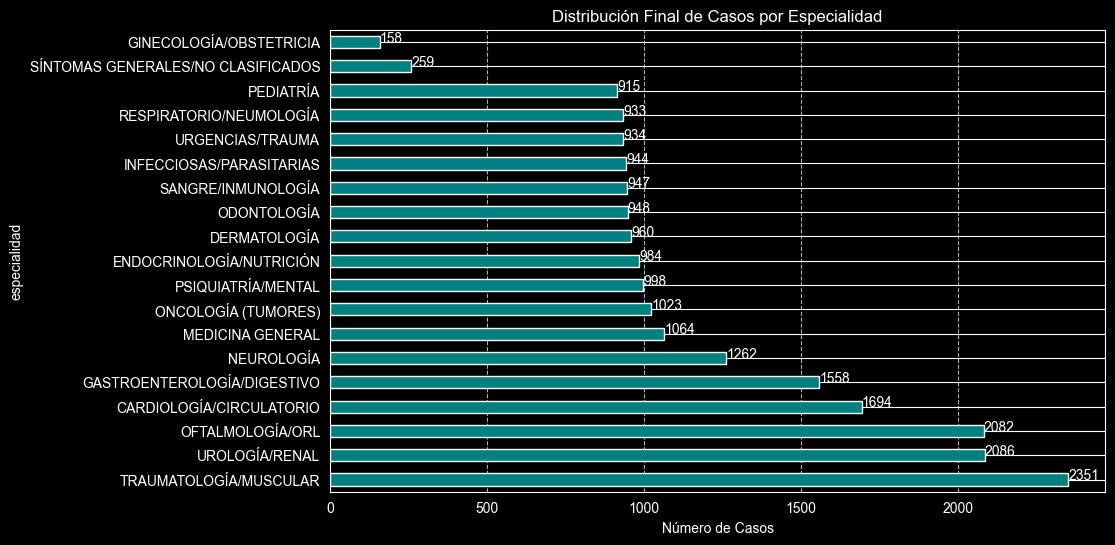

In [15]:
# Verificamos si tenemos suficientes datos por clase
conteo = df_total['especialidad'].value_counts()

plt.figure(figsize=(10,6))
conteo.plot(kind='barh', color='teal')
plt.title('Distribución Final de Casos por Especialidad')
plt.xlabel('Número de Casos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for index, value in enumerate(conteo):
    plt.text(value, index, str(value))

plt.show()

# Advertencia si hay clases muy pobres
clases_pobres = conteo[conteo < 100]
if not clases_pobres.empty:
    print("⚠️ ADVERTENCIA: Las siguientes clases tienen muy pocos datos (<50):")
    print(clases_pobres.index.tolist())
    print("Considera agruparlas en 'Síntomas Generales/No clasificados' o buscar más datos.")

In [16]:
# Guardamos en la carpeta processed
OUTPUT_FILE = os.path.join(PROCESSED_DATA_PATH, 'datos_triaje_unificados.csv')

df_total.to_csv(OUTPUT_FILE, index=False)

print(f"💾 Archivo guardado exitosamente en: {OUTPUT_FILE}")
print("¡Listo para pasar a la fase de preprocesamiento (2.0)!")

💾 Archivo guardado exitosamente en: ../data/processed/datos_triaje_unificados.csv
¡Listo para pasar a la fase de preprocesamiento (2.0)!
